In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree
from datetime import datetime
import joblib
from math import radians, sin, cos, sqrt, atan2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("data4_population_updated.csv")


crime_weights = {"F": 10, "D": 5, "V": 2}
df["crime_weight"] = df["LAW_CAT_CD"].map(crime_weights)

crime_data = df.groupby("NTAName").agg({
    "crime_weight": "sum",       
    "Population": "first"   
}).reset_index()

unique_values = df['NTAName'].nunique()

print(f"Unique NTAName values: {unique_values}")

Unique NTAName values: 252


In [3]:
crime_weight_map = {
    # Highest Severity (Violent / Life Threatening)
    'MURDER & NON-NEGL. MANSLAUGHTE': 10, 'RAPE': 10, 'FELONY ASSAULT': 10, 'SEX CRIMES': 10, 
    'KIDNAPPING & RELATED OFFENSES': 10, 'ARSON': 10, 'HOMICIDE-NEGLIGENT,UNCLASSIFIE': 10, 'HOMICIDE-NEGLIGENT-VEHICLE': 10,
    
    # Very Dangerous
    'ROBBERY': 9, 'BURGLARY': 9, 'GRAND LARCENY OF MOTOR VEHICLE': 9,
    
    # Dangerous Weapons & Assault
    'DANGEROUS WEAPONS': 8, 'DANGEROUS DRUGS': 8, 'ASSAULT 3 & RELATED OFFENSES': 8, 'ESCAPE 3': 8,
    
    # High Impact Theft
    'GRAND LARCENY': 7, 'CRIMINAL MISCHIEF & RELATED OF': 7, 'CRIMINAL TRESPASS': 7, 'POSSESSION OF STOLEN PROPERTY': 7,
    
    # Fraud & Forgery Crimes
    'FRAUDS': 6, 'OFFENSES INVOLVING FRAUD': 6, 'FORGERY': 6, 'THEFT-FRAUD': 6,
    
    # Common Crimes
    'PETIT LARCENY': 5, 'OTHER OFFENSES RELATED TO THEFT': 5, 'DISORDERLY CONDUCT': 5,
    
    # Quality of Life Crimes
    'PROSTITUTION & RELATED OFFENSES': 4, 'GAMBLING': 4, 'INTOXICATED & IMPAIRED DRIVING': 4, 'INTOXICATED/IMPAIRED DRIVING': 4,
    
    # Traffic / Minor Drugs / Alcohol
    'VEHICLE AND TRAFFIC LAWS': 3, 'ALCOHOLIC BEVERAGE CONTROL LAW': 3, 'OTHER STATE LAWS': 3, 'OTHER STATE LAWS (NON PENAL LAW)': 3,
    
    # Very Minor Crimes
    'HARRASSMENT 2': 2, 'JOSTLING': 2, 'LOITERING': 2, 'LOITERING/GAMBLING (CARDS, DIC': 2, 
    
    # Admin / Health / Parking / Noise
    'ADMINISTRATIVE CODE': 1, 'ADMINISTRATIVE CODES': 1, 'MOVING INFRACTIONS': 1, 'PARKING OFFENSES': 1, 
    'FOR OTHER AUTHORITIES': 1, 'NEW YORK CITY HEALTH CODE': 1, 'FORTUNE TELLING': 1, 'DISRUPTION OF A RELIGIOUS SERV': 1,
    '(null)': 1, 'OFFENSES AGAINST PUBLIC ADMINI': 1, 'OFFENSES AGAINST PUBLIC SAFETY': 1, 
    'OFFENSES AGAINST THE PERSON': 1, 'OFF. AGNST PUB ORD SENSBLTY &': 1, 'ANTICIPATORY OFFENSES': 1, 
    'CHILD ABANDONMENT/NON SUPPORT 1': 1, 'OFFENSES RELATED TO CHILDREN': 1, 'BURGLAR\'S TOOLS': 1, 
    'CANNABIS RELATED OFFENSES': 1
}
df['crime_weight'] = df['OFNS_DESC'].map(crime_weight_map).fillna(1)

In [4]:
import pandas as pd
import numpy as np

df['crime_severity'] = df['crime_weight'].apply(lambda x: 'serious' if x >= 8 else 'unserious')
df["ARREST_DATE"] = pd.to_datetime(df["ARREST_DATE"])
df["days_since_crime"] = (pd.Timestamp.now() - df["ARREST_DATE"]).dt.days
decay_factor = 0.99
df["adjusted_crime_weight"] = df["crime_weight"] * np.power(decay_factor, df["days_since_crime"])


crime_data = df.groupby("NTAName").agg({
    "adjusted_crime_weight": "sum",
    "Population": "first"
}).reset_index()

# Drop neighborhoods with missing or zero population
crime_data = crime_data.dropna(subset=["Population"])
crime_data = crime_data[crime_data["Population"] > 0]

# Calculate weighted crime rate per 1,000 residents
crime_data["weighted_crime_rate"] = (crime_data["adjusted_crime_weight"] / crime_data["Population"]) * 1000

# Normalize the weighted crime rate
min_rate = crime_data["weighted_crime_rate"].min()
max_rate = crime_data["weighted_crime_rate"].max()

if max_rate == min_rate:
    crime_data["normalized_weighted_rate"] = 0
else:
    crime_data["normalized_weighted_rate"] = (crime_data["weighted_crime_rate"] - min_rate) / (max_rate - min_rate)

# Invert normalized crime rate to compute safety index
crime_data["safety_index"] = (1 - crime_data["normalized_weighted_rate"]) * 100

# Set display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Show the result sorted by safety
print(crime_data[["NTAName", "adjusted_crime_weight", "Population", "weighted_crime_rate", "safety_index"]].sort_values("safety_index"))


                                                      NTAName  \
117                                           Jackson Heights   
119                                                   Jamaica   
154                                    Mott Haven-Port Morris   
113                                               Hunts Point   
166                                                Ocean Hill   
63                                          East Harlem North   
92                                                   Gramercy   
134                                                  Longwood   
80                                     Flushing-Willets Point   
50                                        Crown Heights South   
156                                                Mount Hope   
144                                                   Melrose   
82                                               Forest Hills   
163                                                   Norwood   
162                      

In [5]:
print(crime_data)

                                                      NTAName  \
0                                                    Allerton   
4                                             Astoria Central   
5                                 Astoria East-Woodside North   
6                              Astoria North-Ditmars-Steinway   
7                                                Astoria Park   
8                                                  Auburndale   
9                                                Baisley Park   
11                                                 Bath Beach   
12                                                  Bay Ridge   
13                                      Bay Terrace-Clearview   
15                                               Bedford Park   
17                                    Bedford-Stuyvesant West   
18                                                  Bellerose   
19                                                    Belmont   
21                       

In [6]:
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)  
pd.set_option('display.max_colwidth', None)  


print(crime_data)

                                                      NTAName  \
0                                                    Allerton   
4                                             Astoria Central   
5                                 Astoria East-Woodside North   
6                              Astoria North-Ditmars-Steinway   
7                                                Astoria Park   
8                                                  Auburndale   
9                                                Baisley Park   
11                                                 Bath Beach   
12                                                  Bay Ridge   
13                                      Bay Terrace-Clearview   
15                                               Bedford Park   
17                                    Bedford-Stuyvesant West   
18                                                  Bellerose   
19                                                    Belmont   
21                       

In [7]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c  # Distance in kilometers

In [8]:
print(crime_data[["NTAName", "weighted_crime_rate", "safety_index"]])

                                                      NTAName  \
0                                                    Allerton   
4                                             Astoria Central   
5                                 Astoria East-Woodside North   
6                              Astoria North-Ditmars-Steinway   
7                                                Astoria Park   
8                                                  Auburndale   
9                                                Baisley Park   
11                                                 Bath Beach   
12                                                  Bay Ridge   
13                                      Bay Terrace-Clearview   
15                                               Bedford Park   
17                                    Bedford-Stuyvesant West   
18                                                  Bellerose   
19                                                    Belmont   
21                       

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


X = crime_data.drop(columns=["safety_index", "NTAName"])  
y = crime_data["safety_index"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(
    random_state=42, 
    n_estimators=100,  
    
    max_depth=10,      
    
    min_samples_split=5,  
    
    min_samples_leaf=2    
    
)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [10]:
def predict_safety(lat, lon, model, radius=0.2):
    df["distance"] = df.apply(lambda row: haversine(lat, lon, row["Latitude"], row["Longitude"]), axis=1)
    crimes_in_radius = df[df["distance"] <= radius]

    if crimes_in_radius.empty:
        return "Very Safe (No crimes found)"

    crime_weight = crimes_in_radius["crime_weight"].sum()
    population = crimes_in_radius["Population"].mean()

    if pd.isna(population) or population <= 0:
        return "Safe (No valid population data)"

    weighted_crime_rate = (crime_weight / population) * 1000

    min_wcr = X_train["weighted_crime_rate"].min()
    max_wcr = X_train["weighted_crime_rate"].max()
    normalized = 0 if max_wcr == min_wcr else (weighted_crime_rate - min_wcr) / (max_wcr - min_wcr)

    features = pd.DataFrame({
        "crime_weight": [crime_weight],
        "Population": [population],
        "weighted_crime_rate": [weighted_crime_rate],
        "normalized_weighted_rate": [normalized]
    })

    for col in X_train.columns:
        if col not in features.columns:
            features[col] = 0

    features = features[X_train.columns]
    safety_index = model.predict(features)[0]

    if safety_index > 85:
        return f"Very Safe (Safety Index: {safety_index:.2f})"
    elif 70 <= safety_index <= 85:
        return f"Safe (Safety Index: {safety_index:.2f})"
    elif 50 <= safety_index < 70:
        return f"Moderately Safe (Safety Index: {safety_index:.2f})"
    else:
        return f"Not Safe (Safety Index: {safety_index:.2f})"


In [11]:
# Mid town manhattan
latitude = 40.795807
longitude =-73.937099

safety_status = predict_safety(latitude, longitude, model)
print(safety_status)

Safe (Safety Index: 72.99)


In [12]:

def get_top_crimes_in_area(lat, lon, radius=0.2, category_column='LAW_CAT_CD', crime_column='OFNS_DESC', top_n=3):
   
    df['distance'] = df.apply(lambda row: haversine(lat, lon, row['Latitude'], row['Longitude']), axis=1)
    df['crime_severity'] = df['crime_weight'].apply(lambda x: 'serious' if x >= 8 else 'unserious')


    crimes_in_radius = df[df['distance'] <= radius]
    

    crime_counts = crimes_in_radius.groupby([category_column, crime_column]).size().reset_index(name='count')
    
    crime_counts = crime_counts.sort_values(by=[category_column, 'count'], ascending=[True, False])
    
 
    top_crimes = crime_counts.groupby(category_column).head(top_n)
    
    return top_crimes



In [13]:

latitude = 40.67024109400334
longitude = -73.90699864
radius = 0.2  

top_crimes_in_area = get_top_crimes_in_area(latitude, longitude, radius)
print(top_crimes_in_area)

   LAW_CAT_CD                     OFNS_DESC  count
2           F               DANGEROUS DRUGS     98
9           F       MISCELLANEOUS PENAL LAW     24
4           F                FELONY ASSAULT     20
17          M               DANGEROUS DRUGS     52
14          M  ASSAULT 3 & RELATED OFFENSES     46
25          M                 PETIT LARCENY     38
28          V           ADMINISTRATIVE CODE      2


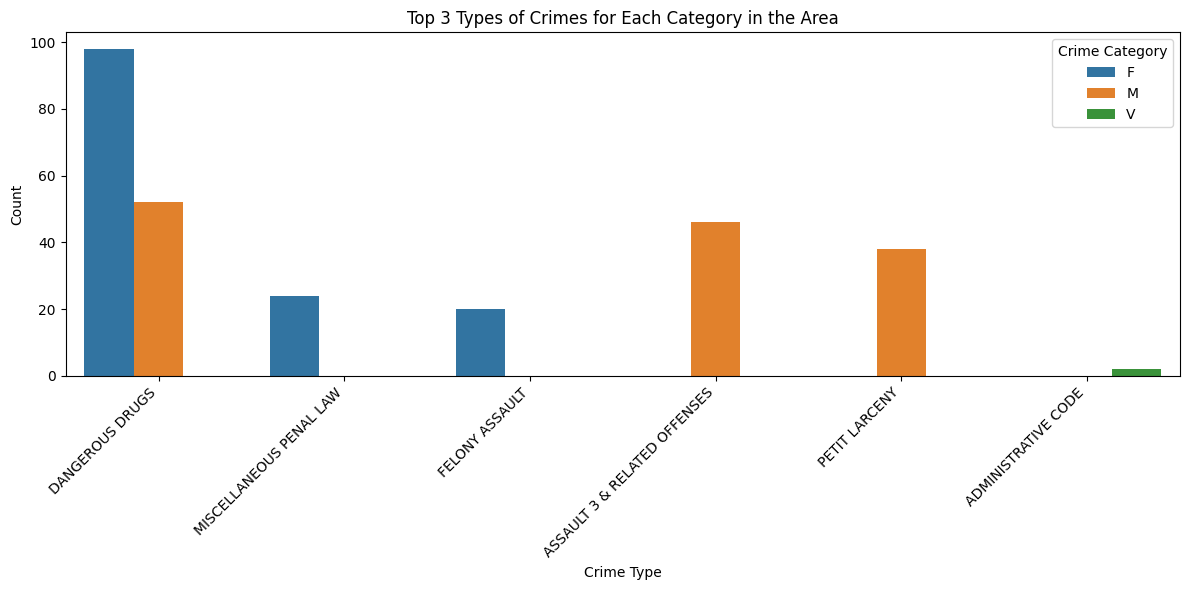

In [14]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_crimes_in_area,
    x='OFNS_DESC',
    y='count',
    hue='LAW_CAT_CD',
    dodge=True
)
plt.title('Top 3 Types of Crimes for Each Category in the Area')
plt.xlabel('Crime Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Crime Category')
plt.tight_layout()
plt.show()

In [15]:
# To save model
import joblib
import pickle
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [16]:
# To load the model

# Using joblib
loaded_model = joblib.load('random_forest_model.pkl')

# Using pickle
with open('random_forest_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [17]:
import folium


latitude = 40.67024109400334
longitude = -73.90699864
# latitude = 40.6586
# longitude = -73.9134

radius_meters = 200 


map_ny = folium.Map(location=[latitude, longitude], zoom_start=14)


folium.Circle(
    location=[latitude, longitude],
    radius=radius_meters,
    color='blue',
    fill=True,
    fill_color='blue',
    fill_opacity=0.2
).add_to(map_ny)


map_ny


In [18]:
#Task 1
def get_top_crimes_in_neighborhood(df, neighborhood_name):
   
    crimes_in_neighborhood = df[df['NTAName'] == neighborhood_name]

  
    top_crimes_neighborhood = crimes_in_neighborhood['OFNS_DESC'].value_counts().head(5)

    return top_crimes_neighborhood


neighborhood_name = 'Jamaica'  
top_crimes = get_top_crimes_in_neighborhood(df, neighborhood_name)
print(f"Top 5 Crimes in {neighborhood_name}:")
print(top_crimes)

Top 5 Crimes in Jamaica:
OFNS_DESC
DANGEROUS DRUGS                    1650
PETIT LARCENY                      1510
ASSAULT 3 & RELATED OFFENSES       1354
OTHER OFFENSES RELATED TO THEFT    1296
FELONY ASSAULT                     1044
Name: count, dtype: int64


In [19]:
#Task 2
def get_top_felony_crimes_in_neighborhood(df, neighborhood_name):
    felony_crimes_neighborhood = df[(df['LAW_CAT_CD'] == 'F') & (df['NTAName'] == neighborhood_name)]
    top_felony_crimes_neighborhood = felony_crimes_neighborhood['OFNS_DESC'].value_counts().head(5)
    return top_felony_crimes_neighborhood


neighborhood_name = 'Jamaica'
top_felony_crimes = get_top_felony_crimes_in_neighborhood(df, neighborhood_name)
print(f"Top 5 Felony Crimes in {neighborhood_name}:")
print(top_felony_crimes)

Top 5 Felony Crimes in Jamaica:
OFNS_DESC
FELONY ASSAULT             1044
MISCELLANEOUS PENAL LAW     730
DANGEROUS DRUGS             726
ROBBERY                     538
FORGERY                     336
Name: count, dtype: int64


In [20]:
def calculate_crime_rates(df, neighborhood_name):
    
    nyc_total_crime_weight = df['adjusted_crime_weight'].sum()
    nyc_total_population = df['Population'].sum()
    nyc_average_crime_rate = (nyc_total_crime_weight / nyc_total_population) * 1000

   
    neighborhood_data = df[df['NTAName'] == neighborhood_name]
    neighborhood_total_crime_weight = neighborhood_data['adjusted_crime_weight'].sum()
    neighborhood_total_population = neighborhood_data['Population'].sum()
    neighborhood_average_crime_rate = (neighborhood_total_crime_weight / neighborhood_total_population) * 1000

    
    df_grouped = df.groupby('NTAName').agg({
        'adjusted_crime_weight': 'sum',
        'Population': 'sum'
    }).reset_index()
    
    df_grouped = df_grouped[df_grouped['Population'] > 0]  # avoid division by zero
    df_grouped['crime_rate'] = (df_grouped['adjusted_crime_weight'] / df_grouped['Population']) * 1000

    min_rate = df_grouped['crime_rate'].min()
    max_rate = df_grouped['crime_rate'].max()

    
    def normalize(rate):
        return (rate - min_rate) / (max_rate - min_rate) if max_rate != min_rate else 0

    return {
        "NYC Average Crime Rate": nyc_average_crime_rate,
        f"{neighborhood_name} Average Crime Rate": neighborhood_average_crime_rate,
        f"{neighborhood_name} Normalized Crime Rate": normalize(neighborhood_average_crime_rate),
        "NYC Normalized Crime Rate": normalize(nyc_average_crime_rate)
    }

neighborhood_name = 'Jamaica'
crime_rates = calculate_crime_rates(df, neighborhood_name)
print(crime_rates)


{'NYC Average Crime Rate': 0.01278791073052399, 'Jamaica Average Crime Rate': 0.01268083413423705, 'Jamaica Normalized Crime Rate': 0.24280694279586987, 'NYC Normalized Crime Rate': 0.2453166251701698}


In [21]:
neighborhood_name = 'Brownsville'
crime_rates = calculate_crime_rates(df, neighborhood_name)
print(crime_rates)

{'NYC Average Crime Rate': 0.01278791073052399, 'Brownsville Average Crime Rate': 0.008739019417718822, 'Brownsville Normalized Crime Rate': 0.150417912327515, 'NYC Normalized Crime Rate': 0.2453166251701698}


In [22]:
#Task 4
def get_crime_breakdown(df, neighborhood_name):
    crimes_in_neighborhood = df[df['NTAName'] == neighborhood_name]
    crime_counts = crimes_in_neighborhood['OFNS_DESC'].value_counts()
    total_crimes = crime_counts.sum()
    crime_breakdown = (crime_counts / total_crimes * 100).round(2)
    return crime_breakdown.to_dict()

neighborhood_name = 'Jamaica'
crime_breakdown = get_crime_breakdown(df, neighborhood_name)
print(crime_breakdown)

{'DANGEROUS DRUGS': 12.29, 'PETIT LARCENY': 11.25, 'ASSAULT 3 & RELATED OFFENSES': 10.08, 'OTHER OFFENSES RELATED TO THEFT': 9.65, 'FELONY ASSAULT': 7.78, 'VEHICLE AND TRAFFIC LAWS': 6.15, 'SEX CRIMES': 5.74, 'MISCELLANEOUS PENAL LAW': 5.51, 'OFFENSES AGAINST PUBLIC ADMINI': 4.62, 'ROBBERY': 4.01, 'CRIMINAL MISCHIEF & RELATED OF': 2.68, 'DANGEROUS WEAPONS': 2.52, 'FORGERY': 2.5, 'OFFENSES INVOLVING FRAUD': 2.28, 'GRAND LARCENY': 1.98, 'BURGLARY': 1.85, 'OFF. AGNST PUB ORD SENSBLTY &': 1.42, 'OTHER TRAFFIC INFRACTION': 1.03, 'POSSESSION OF STOLEN PROPERTY': 0.97, 'GRAND LARCENY OF MOTOR VEHICLE': 0.74, 'FRAUDS': 0.7, 'OTHER STATE LAWS': 0.69, 'CRIMINAL TRESPASS': 0.61, 'PROSTITUTION & RELATED OFFENSES': 0.46, 'MURDER & NON-NEGL. MANSLAUGHTE': 0.42, 'INTOXICATED & IMPAIRED DRIVING': 0.37, 'OFFENSES AGAINST THE PERSON': 0.33, 'RAPE': 0.19, "BURGLAR'S TOOLS": 0.18, 'HARRASSMENT 2': 0.13, 'CANNABIS RELATED OFFENSES': 0.12, 'UNAUTHORIZED USE OF A VEHICLE': 0.12, 'DISORDERLY CONDUCT': 0.1, 'A

In [23]:
def calculate_borough_safety_index(df):
   
    borough_data = df.groupby('BoroName').agg({
        'adjusted_crime_weight': 'sum',
        'Population': 'sum'
    }).reset_index()

   
    borough_data = borough_data[borough_data['Population'] > 0]

    
    borough_data['crime_rate'] = (borough_data['adjusted_crime_weight'] / borough_data['Population']) * 1000

    # Min-max normalization to derive safety index
    min_rate = borough_data['crime_rate'].min()
    max_rate = borough_data['crime_rate'].max()

    if max_rate == min_rate:
        borough_data['safety_index'] = 1  
    else:
        borough_data['safety_index'] = 1 - ((borough_data['crime_rate'] - min_rate) / (max_rate - min_rate))

    return borough_data[['BoroName', 'crime_rate', 'safety_index']].sort_values(by='safety_index', ascending=False)


In [24]:
calculate_borough_safety_index(df)

,BoroName,crime_rate,safety_index
2,Manhattan,0.010857,1.000000
1,Brooklyn,0.011905,0.898846
3,Queens,0.013184,0.775463
0,Bronx,0.015609,0.541508
4,Staten Island,0.021220,0.000000
